# **C-calculate_teleconnection.ipynb**

Author: Zhixian Yang

Email: [yangzhx28@mail2.sysu.edu.cn](mailto:yangzhx28@mail2.sysu.edu.cn) or [yimu01439@gmail.com](mailto:yimu01439@gmail.com)

GitHub: [https://github.com/koar-create](https://github.com/koar-create)

Date created: July 27th, 2023

Last modified: July 27th, 2023

<br><br>

---

<br><br>

## **Description**
This document is a Jupyter Notebook designed for an exercise derived from the "Computational Tools for Climate Science 2023" course offered by Climatematch Academy. The code presented here comprises a combination of materials provided in the course and code obtained from online sources.

# <font color='red'>1. download and import packages</font>

In [1]:
!pip install cdsapi --quiet
!pip install imageio[ffmpeg] --quiet
!pip install imageio[pyav] --quiet

import imageio
import cdsapi
import h5py
import urllib.request
from itertools import product
import s3fs, boto3, botocore, pooch
from pythia_datasets import DATASETS
import os, sys, glob, platform, tempfile
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader

# <font color='red'>2. read data</font>

## 2.1. precipitation

<br>

### **<font face='Arial' size=4>Yang: option 1 is the file `precip.mon.mean.nc` under the folder `shared/Data/Projects/ENSO` with time resolution of 1-month.</font>**

In [ ]:
# # data source 1
# ds = xr.open_dataset('shared/Data/Projects/ENSO/precip.mon.mean.nc')
# ds

<br>

### **<font face='Arial' size=4>Yang: option 2 is the file `NCEP-NCAR version 1` ReAnalysis Dataset under the folder `shared-public/Megaraptor_Pop_Fortepiano/NCEP-NCAR-v1` with time resolution of 1-day and 1-month.</font>**

In [ ]:
# # data source 2: ncep-ncar v1
# temporal_res = 'daily'
# start_year, end_year = 1995, 2000
# sfc_var_list  = ['lftx.sfc', 'lftx4.sfc', 'pres.sfc', 'pr_wtr.eatm', 'slp']

# for idx, var in enumerate(sfc_var_list):
#     ds_list = []
#     for year in range(start_year, end_year + 1):
#         file_path = os.path.join('NCEP-NCAR-v1', 'daily', 'surface', f"{var}.{year}.nc")
#         ds_temp = xr.open_dataset(file_path)
#         ds_list.append(ds_temp.sel(time=ds_temp.time.dt.hour == 0))
#         del ds_temp
#     ds_temp = xr.concat(ds_list, dim='time')
#     ds_sfc_daily = ds_temp if idx == 0 else xr.merge([ds_sfc_daily, ds_temp])
#     del ds_temp

<br>

### **<font face='Arial' size=4>Yang: option 3 is `ERA5` ReAnalysis Dataset under the folder `shared-public/Megaraptor_Pop_Fortepiano/ERA5` with time resolution of 1-day and 1-month.</font>**

In [3]:
# # data source 3: ERA5
# ds = xr.open_dataset(os.path.join('Data', 'ERA5', 'hourly', 'single_level', '1996-2005_SH.nc'))
# ds

<br>

### **<font face='Arial' size=4>Yang: option 4 is `TRMM` Datasets with time resolution of 1-day.</font>**

In [ ]:
# data source 4: TRMM
start_year, end_year = 2001, 2010
mission = '3B42'
idx = 0
for year in range(start_year, end_year + 1):
    for month in range(1, 12 + 1):
        version = '7' if ((year < 2000)|(year > 2010)|((year == 2010)&(month >= 10))) else '7A'
        for day in range(1, 31 + 1):
            file_path = os.path.join('/home/jovyan', 'Data', 'TRMM', mission, f'{year}', f'{month:02}', f'{day:02}', f'{mission}.{year}{month:02}{day:02}.00.{version}.HDF5')
            if os.path.exists(file_path):
                with h5py.File(file_path, 'r') as hf:
                    data = hf['/Grid/precipitation'][:].transpose()
                data = np.where(data <= 0.0, 0.0, data).reshape(1, data.shape[0], data.shape[1])
                da_temp = xr.DataArray(data, coords=[pd.date_range(f'{year}-{month:02}-{day:02}', periods=1), np.arange(50.0, -50.0, -0.25), np.arange(-180.0, 180.0, 0.25)], dims=['time', 'lat', 'lon'])
                del data
                da = xr.concat([da, da_temp], dim='time') if idx != 0 else da_temp
                del da_temp
                idx += 1
            else:
                print(f"{file_path.split('/')[-1]} does not exist.")
ds = xr.Dataset({'prcp': da})
del da
ds

3B42.20010229.00.7A.HDF5 does not exist.
3B42.20010230.00.7A.HDF5 does not exist.
3B42.20010231.00.7A.HDF5 does not exist.
3B42.20010431.00.7A.HDF5 does not exist.
3B42.20010631.00.7A.HDF5 does not exist.
3B42.20010931.00.7A.HDF5 does not exist.
3B42.20011131.00.7A.HDF5 does not exist.
3B42.20020229.00.7A.HDF5 does not exist.
3B42.20020230.00.7A.HDF5 does not exist.
3B42.20020231.00.7A.HDF5 does not exist.
3B42.20020431.00.7A.HDF5 does not exist.
3B42.20020631.00.7A.HDF5 does not exist.
3B42.20020931.00.7A.HDF5 does not exist.
3B42.20021131.00.7A.HDF5 does not exist.
3B42.20030229.00.7A.HDF5 does not exist.
3B42.20030230.00.7A.HDF5 does not exist.
3B42.20030231.00.7A.HDF5 does not exist.
3B42.20030431.00.7A.HDF5 does not exist.
3B42.20030631.00.7A.HDF5 does not exist.
3B42.20030931.00.7A.HDF5 does not exist.
3B42.20031131.00.7A.HDF5 does not exist.
3B42.20040230.00.7A.HDF5 does not exist.
3B42.20040231.00.7A.HDF5 does not exist.
3B42.20040431.00.7A.HDF5 does not exist.
3B42.20040631.00

In [ ]:
ds.prcp.attrs['long_name'] = 'total precipitation'
ds.prcp.attrs['units'] = 'mm/day'
if not os.path.exists(os.path.join('Data', 'TRMM', mission, 'netcdf')):
    os.makedirs(os.path.join('Data', 'TRMM', mission, 'netcdf'))
ds.to_netcdf(os.path.join('Data', 'TRMM', mission, 'netcdf', f'{start_year}-{end_year}.nc'), format='NETCDF4', mode='w')

In [3]:
# data source 4: TRMM
mission = '3B42'
ds_0109 = xr.open_dataset(os.path.join(os.getcwd(), 'Data', 'TRMM', mission, 'netcdf', f"{2001}-{2009}.nc"))
ds_10 = xr.open_dataset(os.path.join(os.getcwd(), 'Data', 'TRMM', mission, 'netcdf', f"{2010}-{2010}.nc"))

## 1.2. ENSO Index

In [ ]:
file_path = pooch.retrieve(
    url='https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt', 
    fname=os.path.join(tempfile.gettempdir(), 'detrend.nino34.ascii.txt'), 
    known_hash=None, processor=None, 
)
with open(file_path, 'r+') as f:
    content = f.read()
    if '  ' in content:
        new_content = content.replace('  ', ' ').replace('  ', ' ').replace('  ', ' ').replace(' ', ',').replace(',YR', 'YR').replace('ANOM,', 'ANOM')
        f.seek(0)
        f.write(new_content)

In [ ]:
df = pd.read_csv(file_path, sep=',')
index_to_delete = int(df.index[df['YR'] == '46'].values)
df = df.drop(index=df.index[index_to_delete:])

years = df['YR'].values
months = df['MON'].values
ONI = df['ANOM'].values
dates = [datetime(int(year), int(month), 1) for year, month in zip(years, months)]

In [ ]:
dates

# <font color='red'>3. calculate ENSO teleconnections</font>

In [ ]:
# specify a location: (0°, 110.0°E), and a time period (June, 1996 - May, 1997)
precip_9697 = ds.tp.sel(time=((ds.time.dt.year==1996)&(ds.time.dt.month>=6))|((ds.time.dt.year==1997)&(ds.time.dt.month<=5)) , longitude=110.0, latitude=0.0, method='nearest')

# array used to find the onset date of monsoon
larger_than_40mm = np.where(precip_9697 < 50, 0, 1)
less_than_5mm    = np.where(precip_9697 > 5 , 0, 1)
ten_dry_days     = np.zeros(precip_9697.shape)

# some easy conditional operation
for i in range(0, len(precip_9697) - 9):
    if sum(less_than_5mm[i:(i + 10)]) == 10:
        ten_dry_days[i] = 1
for idx in range(0, len(precip_9697) - 4):
    if (sum(larger_than_40mm[idx:(idx + 5)]) == 5) & (sum(ten_dry_days[idx:(idx + 30)]) == 0):
        break

onset_date = datetime.strptime(np.datetime_as_string(precip_9697.time.values[idx], unit='s'), '%Y-%m-%dT%H:%M:%S').strftime('%Y-%m-%d')
print(f"{onset_date} is the onset date of monsoon this year. ")

In [ ]:
(1000 * precip_9697).plot()
plt.plot(precip_9697.time, larger_than_40mm)
plt.plot(precip_9697.time, less_than_5mm)
plt.legend(['precip', '40', '5'])

In [ ]:
proj = ccrs.Mercator(central_longitude=180.0)
fig, ax = plt.subplots(subplot_kw={'projection': proj})
im = ax.pcolormesh(np.linspace(0, 360, data.shape[1]), np.linspace(50, -50, data.shape[0]), data, 
                   transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', alpha=0.6, linewidth=0.8, linestyle='dashed')
gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()

cbar = fig.colorbar(im, label='units: m', orientation='horizontal')

## 3. some visualization

In [5]:
ds_0203 = ds_0109.sel(time=(((ds_0109.time.dt.year==2002)&(ds_0109.time.dt.month>=6))|
                           ((ds_0109.time.dt.year==2003)&(ds_0109.time.dt.month<=5)))).squeeze()
ds_0203

<xarray.Dataset>
Dimensions:  (time: 365, lat: 400, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01 2002-06-02 ... 2003-05-31
  * lat      (lat) float64 50.0 49.75 49.5 49.25 ... -49.25 -49.5 -49.75 -50.0
  * lon      (lon) float64 0.0 0.1251 0.2502 0.3753 ... 179.6 179.7 179.9 180.0
Data variables:
    prcp     (time, lat, lon) float32 ...

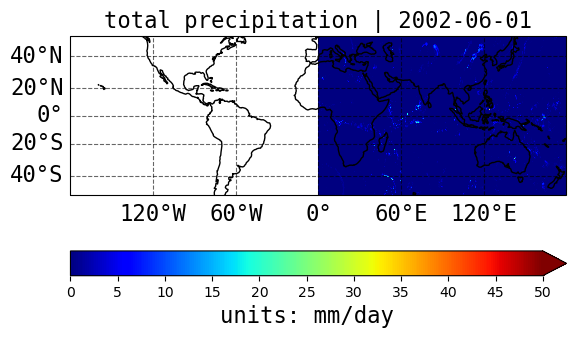

In [7]:
fontdict = {'family': 'Monospace', 'size': 16, 'style': 'normal', 'weight': 'normal', 'alpha': 1, 'color': 'k'}
vmin, vmax = 0, 50
levels = np.linspace(vmin, vmax, 11)
for idx in range(len(ds_0203.time)):
    val = ds_0203.prcp.isel(time=idx).squeeze()
    date = np.datetime_as_string(val.time.values, unit='s').split('T')[0]

    proj = ccrs.Mercator(central_longitude=0.0)
    fig, ax = plt.subplots(subplot_kw={'projection': proj})
    im = ax.pcolormesh(val.lon, val.lat, val, transform=ccrs.PlateCarree(), 
                       vmin=vmin, vmax=vmax, cmap='jet')
    ax.coastlines()
    ax.set_title(f"{ds_0203.prcp.attrs['long_name']} | {date}", fontdict=fontdict)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', alpha=0.6, linewidth=0.8, linestyle='dashed')
    gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()
    gl.right_labels, gl.top_labels = False, False
    gl.xlabel_style, gl.ylabel_style = fontdict, fontdict
    cbar = fig.colorbar(im, orientation='horizontal', 
                        ticks=levels, extend='max')
    cbar.set_label(f"units: {ds_0203.prcp.attrs['units']}", fontdict=fontdict)
    if not os.path.exists('Figure'):
        os.makedirs('Figure')
    plt.savefig(os.path.join('Figure', f"{date}.png"), dpi=200)
    plt.show()
    break

<font size=5>↓ a code block used to generate videos</font>

In [ ]:
file_nlst = [os.path.join("Figure", f"{np.datetime_as_string(date, unit='s').split('T')[0]}.png") for date in ds_0203.time.values]
frame = [imageio.imread(file_name) for file_name in file_nlst]
if not os.path.exists('Video'):
    os.makedirs('Video')
imageio.mimsave(os.path.join('Video', '0203.mp4'), frame, fps=10, macro_block_size=None, codec="libx264", quality=10)